<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [0]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


StopIteration: ignored

In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


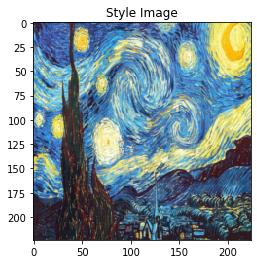

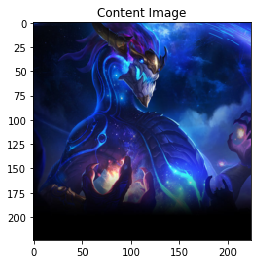

In [0]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_req = [0,5,10]
content_VGG = VGGIntermediate(content_req).cuda()
print(content_image.size())
contentLayer = content_VGG(content_image)
# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
style_req = [0,5,10,17,24]
style_VGG = VGGIntermediate(style_req).cuda()
print(style_image.size())
styleLayer = style_VGG(style_image)
# Cache the outputs of the content and style layers for their respective images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


p is content image, x is current input, L is layer 

f is output at layer L, i is filter , j is filter index. 

P is output of layer when you fed in original content image.


Style Loss

A is output 


In [0]:

def gram_matrix(input):
  a, b, c, d = input.size()  
  features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
  G = torch.mm(features, features.t()) 
  return G.div(a*b*c*d)
  
class ContentLoss(nn.Module):
  def __init__(self):
    super(ContentLoss, self).__init__()
    
    
  def forward(self, F, P):
   return torch.nn.functional.mse_loss(F, P)
  
class StyleLoss(nn.Module):
  def __init__(self):
    super(StyleLoss, self).__init__()

  def forward(self, yhat ,ytruth ):
    style = gram_matrix(ytruth)
    combo = gram_matrix(yhat) 
    mySum = torch.nn.functional.mse_loss(combo, style)
    return mySum

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


tensor(109.2024, device='cuda:0', grad_fn=<AddBackward0>)


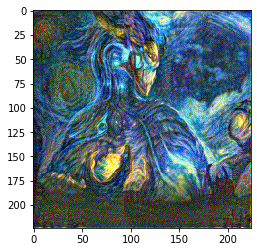

In [0]:
# Start with a copy of the content image

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
  
# Show the image

input_img = content_image.clone().cuda()

optimizer = optim.Adam([input_img.requires_grad_()], lr=0.07)
model = VGGIntermediate([0,5,10,17,24]).cuda()

objectiveContent = ContentLoss()
objectiveStyle = StyleLoss()
lossesArray = []

for epoch in range(700):
  myContentLoss = 0
  myStyleLoss = 0
  optimizer.zero_grad()
  input_dict = model(input_img)

  for key in contentLayer:
    content_layer = contentLayer.get(key)
    input_layer = input_dict.get(key)
    myContentLoss += objectiveContent(input_layer, content_layer.detach())

  for key in styleLayer:
    style_layer = styleLayer.get(key)
    input_layer = input_dict.get(key)
    myStyleLoss += objectiveStyle(input_layer, style_layer.detach())
  
  loss = 15999 * myStyleLoss + myContentLoss
  lossesArray.append(loss)
  loss.backward()
  optimizer.step()


output_img = torch.clamp(input_img, 0, 1)
print(lossesArray[-1])
display(output_img)

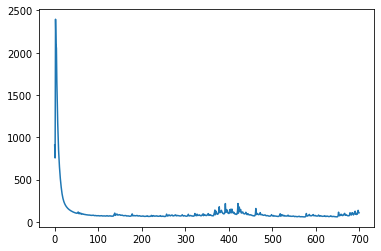

In [0]:
plt.plot(lossesArray)

p is content image, x is current input, L is layer

f is output at layer L, i is filter , j is filter index.

P is output of layer when you fed in original content image.

Style Loss

A is output

G is gram matrix. 



### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

This equation measures the difference between the content of my combined image and the actual content image after both are fed through the cnn. L total output by the cnn at the requested layer. P is the actual content image. X is the current input image.  F is the output at layer l. i is the filter, or channel. j is the filter index number. This compares every pixel with every other pixel from the content picture to the output of my cnn. 



- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

This is the Gram Matrix. It calculates the correlation between the different filters. F is the pixel. i is the first filter it's comparing. j is the other filter it is comparing. l is the layer. 

- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

This is the equation that calculates the style difference between my output from the cnn and the output of the style cnn. G is the output of the Gram Matrix of the original style image. A is the Gram Matrix of the output of my cnn. i is the filter, j is the filter index, l is the layer. N is the height of image. M is the width of the image. 


- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

This calculates the total style loss of the difference between my output and the style output. It the style loss from the above formula times a weight, W. The weight is unique to that layer, l. For all the layers. 


**DONE:**